In [3]:
import warnings
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
import os
import numpy as np
warnings.filterwarnings('ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed=42
seed_everything(seed)

In [41]:
%config Completer.use_jedi=True

In [42]:
# Data Lodding
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
dat_dict = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')

In [43]:
# Metadata check
dat_dict

,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN
5,hla_high_res_8,Recipient / 1st donor allele-level (high resol...,Numerical,NaN
6,tbi_status,TBI,Categorical,"['No TBI' 'TBI + Cy +- Other' 'TBI +- Other, <..."
7,arrhythmia,Arrhythmia,Categorical,['No' nan 'Yes' 'Not done']
8,hla_low_res_6,Recipient / 1st donor antigen-level (low resol...,Numerical,NaN
9,graft_type,Graft type,Categorical,['Peripheral blood' 'Bone marrow']


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [45]:
# Data Size Check
print(f'Training Data \n Sample: {train.shape[0]}\n Features: {train.shape[1]}\n')
print(f'Test Data \n Sample: {test.shape[0]}\n Features: {test.shape[1]}')

Training Data 
 Sample: 28800
 Features: 60

Test Data 
 Sample: 3
 Features: 58


In [46]:
# Check Missing Percentages
def replace_NA(data):
    '''
    Replacing NA value for  real NA value

    Returns:
    completed NA sorted dataframe
    '''
    for col in data.select_dtypes(include=['object', 'category']).columns:
        data[col] = data[col].str.strip().str.lower().replace(
            {'n/a' : None, 'na': None, 'nan': None, '-': None},
            regex=True
        )

    return data

def cal_none_per(data):
    '''
    Calculate Missing Percnetage

    Returns:
    Missing data percenatages per column
    '''
    miss_per = ((data.isnull().sum()) / len(data)) * 100
    return miss_per


def cut_miss(data, threshold):
    '''
    Remove columns that can not be reached missing percenatage threshold

    Return:
    Remvoed target columns data
    '''

    target_cols = miss_df[miss_df<threshold].index

    data =  data[target_cols]

    return data

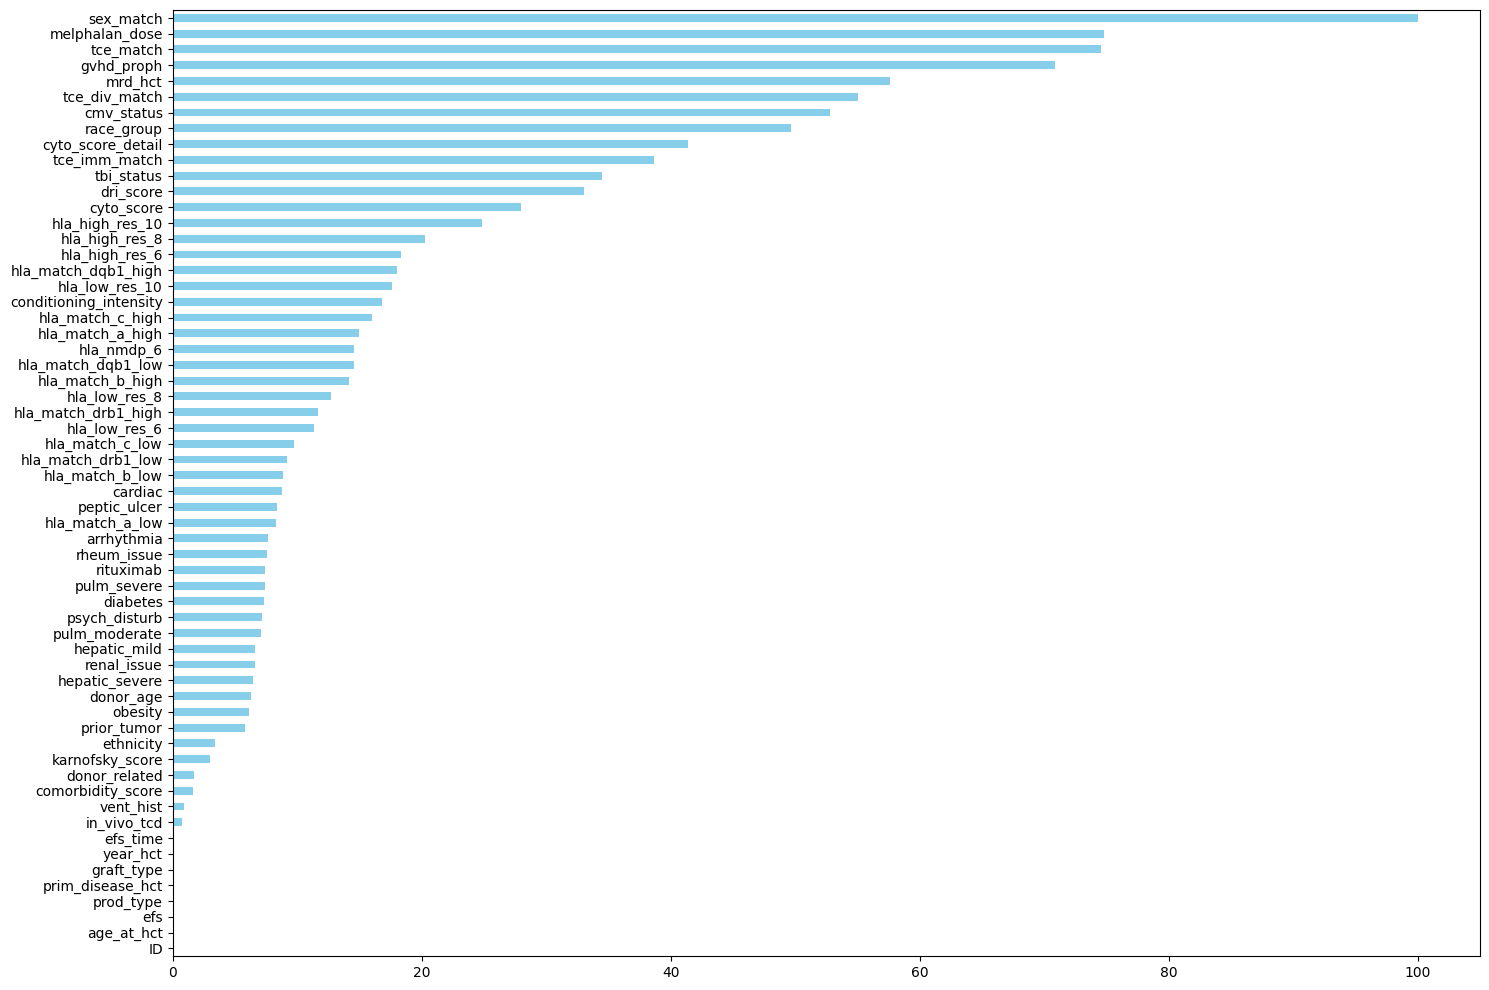


 Missing Feature Percentages



sex_match                 100.000000
melphalan_dose             74.791667
tce_match                  74.545139
gvhd_proph                 70.888889
mrd_hct                    57.628472
tce_div_match              55.083333
cmv_status                 52.791667
race_group                 49.625000
cyto_score_detail          41.399306
tce_imm_match              38.656250
tbi_status                 34.510417
dri_score                  33.079861
cyto_score                 28.013889
hla_high_res_10            24.871528
hla_high_res_8             20.239583
hla_high_res_6             18.347222
hla_match_dqb1_high        18.052083
hla_low_res_10             17.583333
conditioning_intensity     16.843750
hla_match_c_high           16.041667
hla_match_a_high           14.934028
hla_nmdp_6                 14.572917
hla_match_dqb1_low         14.562500
hla_match_b_high           14.194444
hla_low_res_8              12.684028
hla_match_drb1_high        11.638889
hla_low_res_6              11.354167
h

In [47]:
# Visualize missing percentage features

train = replace_NA(train)
test = replace_NA(test)


miss_df = cal_none_per(train)

plt.figure(figsize=(15, 10))
miss_df.sort_values().plot(kind='barh', color='skyblue')
plt.tight_layout()
plt.show()


print(f'\n Missing Feature Percentages\n')
display(miss_df.sort_values(ascending=False))

In [48]:
# Remove columns that missing percentages over 40%

train = cut_miss(train, 40.0) # Threshold=40.0

print(f'After filteration remains column: {train.shape[1]}')

After filteration remains column: 51


In [55]:
def data_processing(data, id_column, target_column=None):
    '''
    Exclude target & id column in dataset


    Returns:
    num_cols: Numerical Columns
    cat_cols: Categorical Columns
    '''

    # Numerical columns preprocessing
    num_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if target_column and target_column in num_cols:
        num_cols.remove(target_column)
    if id_column in num_cols:
        num_cols.remove(id_column)


    # Categorical columns preprocessing
    cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

    return num_cols, cat_cols


def data_imputation(train, test, num_cols, cat_cols):
    '''
    Imputate missing data

    Returns
    Datafram that imputate target columns
    '''

    print('Imputing numerical columns...')
    num_imputer = IterativeImputer(max_iter=10, random_state=seed)
    
    target_cols = ['efs', 'efs_time']

    imp_cols = [col for col in num_cols if col not in target_cols]
    
    for i in tqdm(range(num_imputer.max_iter), desc='Numerical Imputation Progress'):
        train[imp_cols] = num_imputer.fit_transform(train[imp_cols])
        test[imp_cols] = num_imputer.transform(test[imp_cols])

    
    cat_imputer = SimpleImputer(strategy='most_frequent')
    train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])
    test[cat_cols] = cat_imputer.transform(test[cat_cols])


    print(f'Imputation Done.')
    return train, test

def col_matching(train, test):
    '''
    Column Matching between train test 

    Returns:
    Matching Data
    '''

    target_cols = train.columns
    target_cols = [col for col in target_cols if col not in ['efs', 'efs_time']]

    
    test = test[target_cols]

    return test


def column_processor(train, test, num_cols, cat_cols):
    '''
    Scale numerical columns and one-hot encode categorical columns.

    Returns:
    Processed train and test DataFrames.
    '''
    # Exclude target columns
    target = train['efs']

    exclude_cols = [col for col in num_cols if col not in ['efs', 'efs_time']]
    
    # Define transformers
    num_scaler = RobustScaler()
    cat_encoder = OneHotEncoder(handle_unknown='ignore')

    # ColumnTransformer
    transf = ColumnTransformer(
        transformers=[
            ('num', num_scaler, exclude_cols),
            ('cat', cat_encoder, cat_cols)
        ]
    )

    # Apply transformations
    train_transformed = transf.fit_transform(train)
    test_transformed = transf.transform(test)

    # Get encoded column names
    cat_encoded_columns = transf.named_transformers_['cat'].get_feature_names_out(cat_cols)

    # Combine transformed data into DataFrames
    train_processed = pd.DataFrame(
        train_transformed,
        columns=exclude_cols + list(cat_encoded_columns),
        index=train.index
    )
    test_processed = pd.DataFrame(
        test_transformed,
        columns=exclude_cols + list(cat_encoded_columns),
        index=test.index
    )

    return train_processed, test_processed, target

In [50]:
# Assign numerical cols & categorical cols
num_cols, cat_cols = data_processing(train, id_column='ID')

In [51]:
# Data Imputation
train, test = data_imputation(train, test, num_cols, cat_cols)

Imputing numerical columns...


Numerical Imputation Progress: 100%|██████████| 10/10 [01:09<00:00,  6.96s/it]


Imputation Done.


In [52]:
# Columns matching between train & test data
test = col_matching(train, test)

In [56]:
# Column Preprocessing
train, test, y = column_processor(train, test, num_cols, cat_cols)

In [57]:
def corr_calculation(data, target_cols):
    '''
    Calculate correlation between columns

    Returns:
    Correlation Matrix
    '''

    corr_matrix = data[target_cols].corr()

    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.tight_layout()
    plt.show()

    return corr_matrix

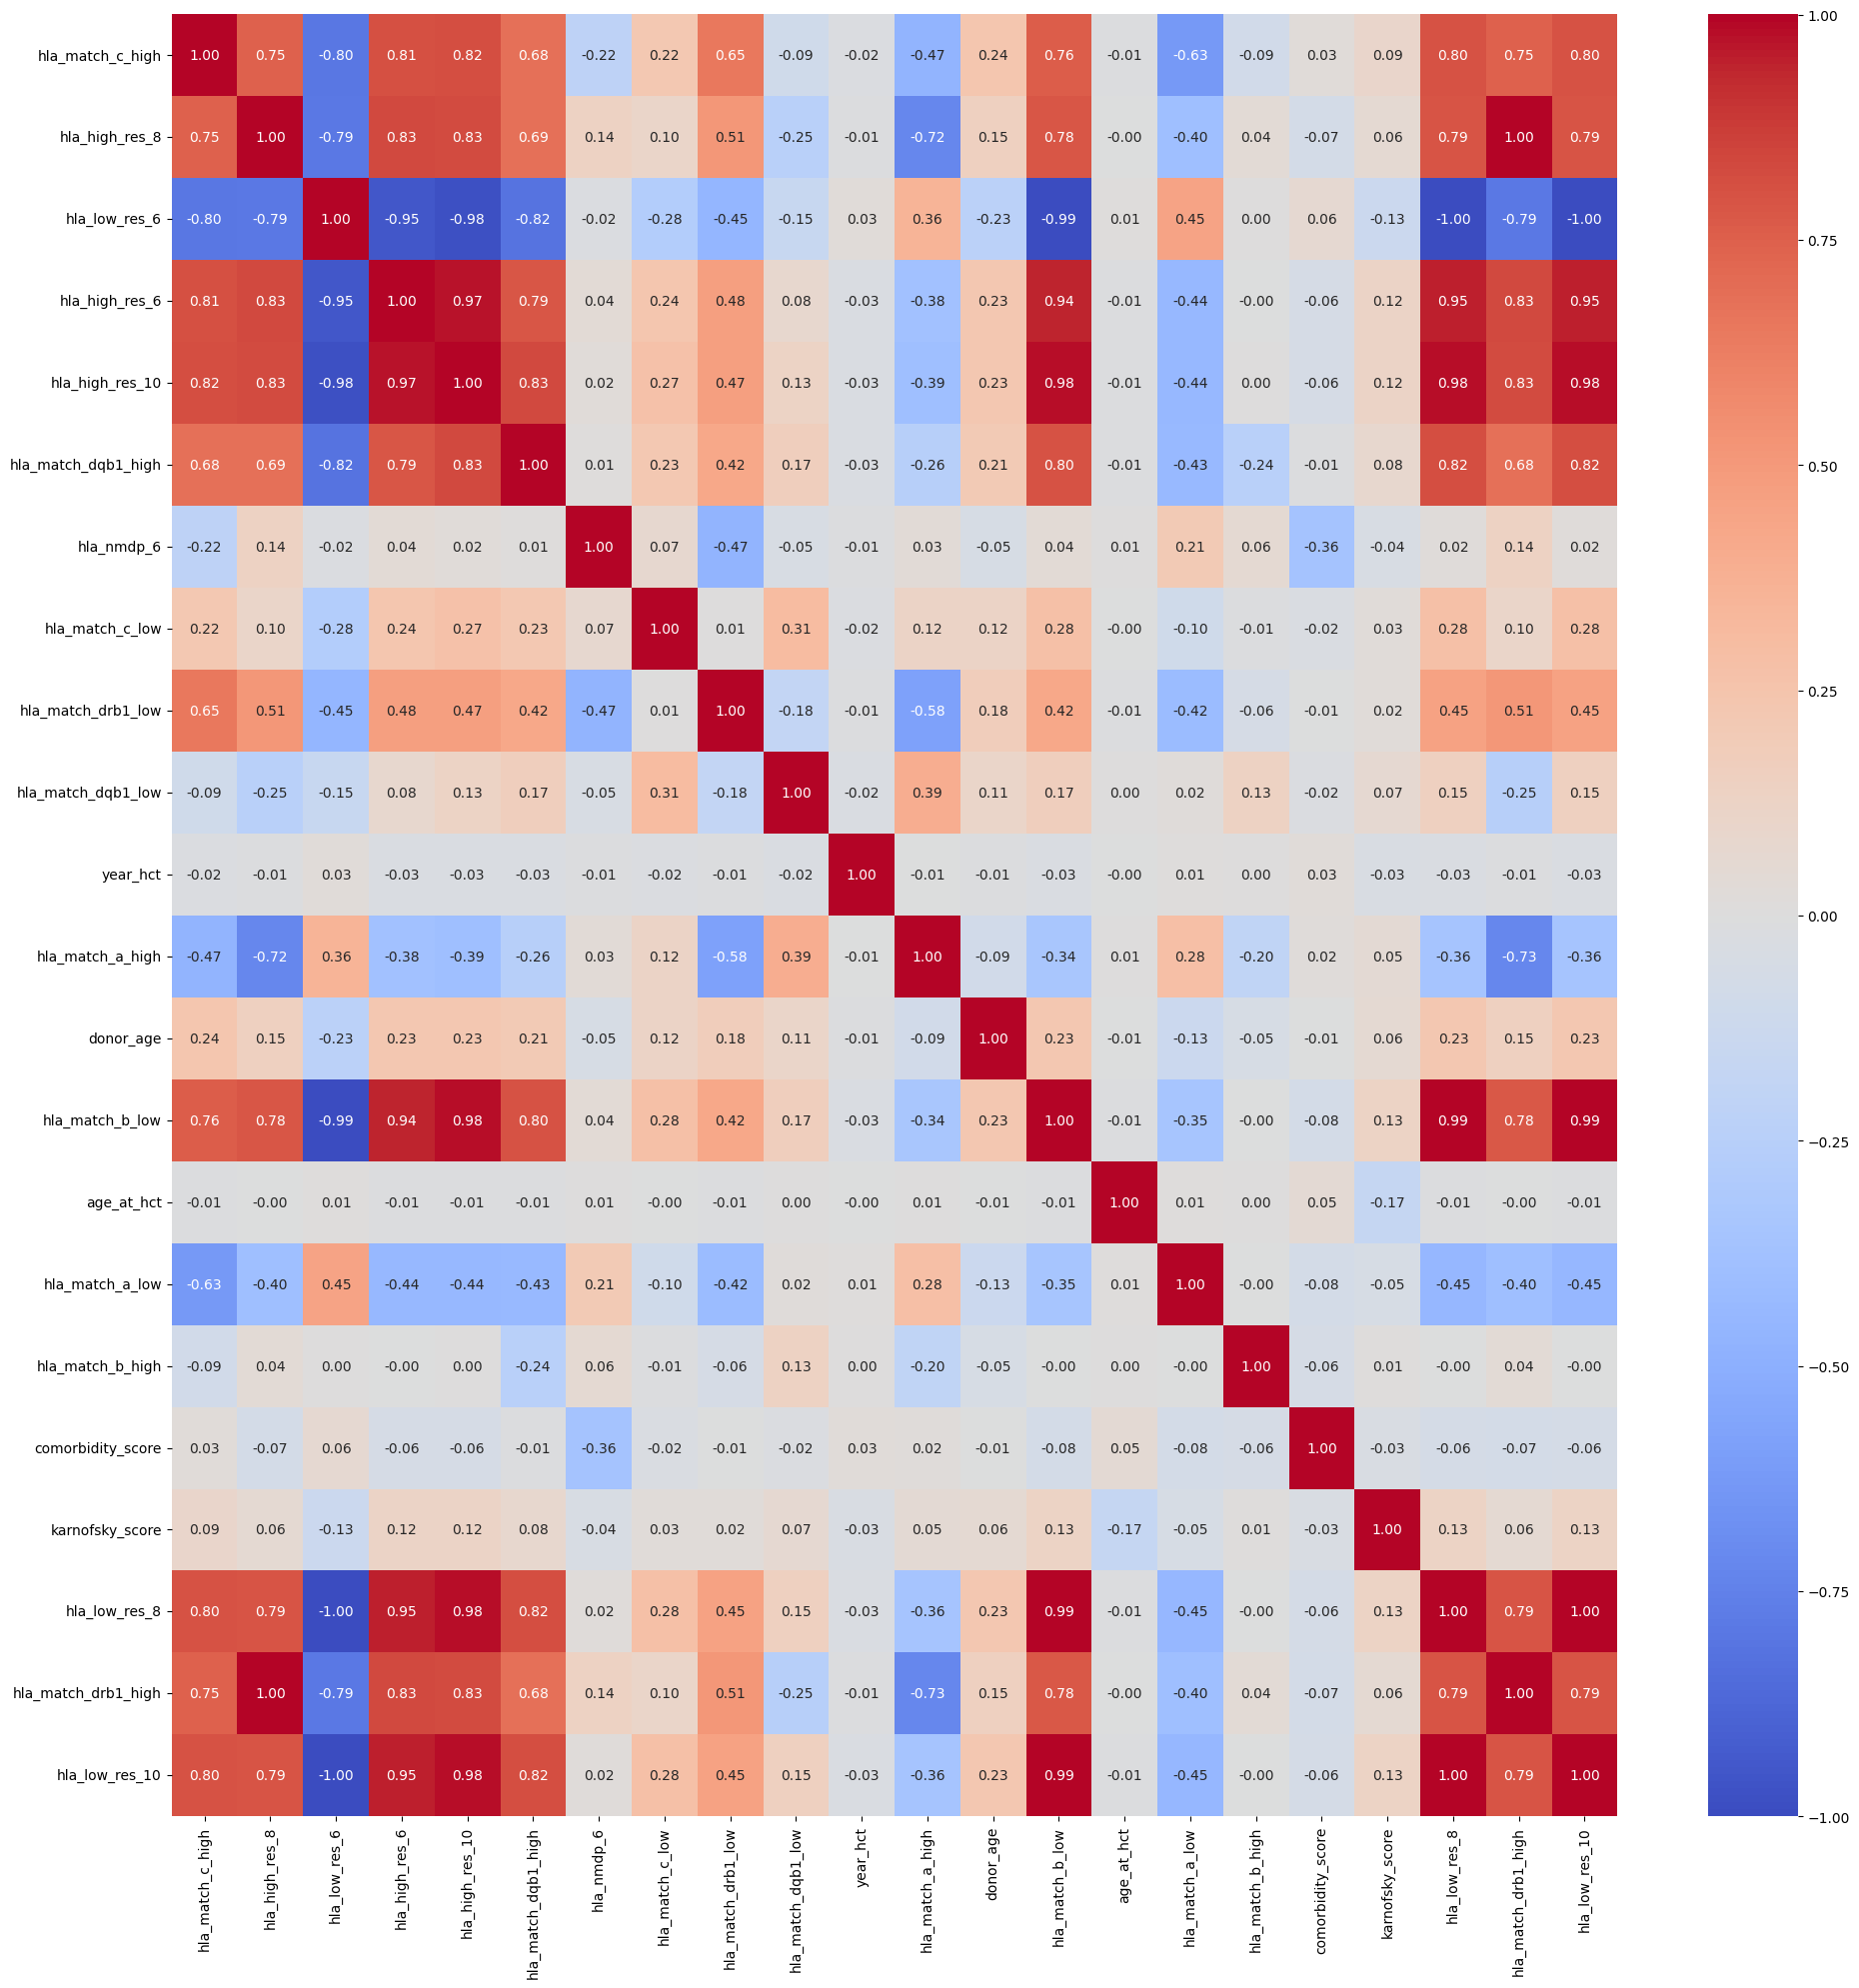

In [60]:
# Correlation Check
corr_cols = [col for col in num_cols if col not in ['efs', 'efs_time']]
corr_matrix = corr_calculation(train, corr_cols)

In [61]:
def TrainML(X, y, test, target_column, n_split=5, seed=seed):

    '''
    CatBoost Baseline Model

    Return:
    Model with Results
    '''

    kfold = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)

    test_preds = np.zeros((len(test), n_split))


    cat_model = CatBoostRegressor(learning_rate=0.1, depth=6, iterations=200, random_state=seed, verbose=0)

    c_indices=[]
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(kfold.split(X, y), desc='Training Folds', total=kfold.n_splits)):

        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        cat_model.fit(X_train, y_train)
        y_val_pred = cat_model.predict(X_val)

        mse = mean_squared_error(y_val, y_val_pred)
        rmse = np.sqrt(mse)
        c_index = concordance_index()

        test_preds[:, fold] += cat_model.predict(test)

        print(f'RMSE Score: {rmse}')

    return cat_model

In [63]:
# Train Model 
X = train

best_model = TrainML(X, y, test, 'efs')

Training Folds:  20%|██        | 1/5 [00:01<00:06,  1.73s/it]

RMSE Score: 0.46345377606553095


Training Folds:  40%|████      | 2/5 [00:03<00:05,  1.68s/it]

RMSE Score: 0.45347631126616506


Training Folds:  60%|██████    | 3/5 [00:05<00:03,  1.67s/it]

RMSE Score: 0.4529122243378429


Training Folds:  80%|████████  | 4/5 [00:06<00:01,  1.64s/it]

RMSE Score: 0.4558362957059229


Training Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]

RMSE Score: 0.4561588319599701
